In [1]:
from modules.settings import global_mmf_settings as gset
from data_preprocess import preprocess_planck_psm_data_esz_cat as ppd
from modules.simulate.spatial_template import sz_pressure_profile as szp
from simulate import cluster_templates as cltemp
from flat_sky_codes import flat_sky_analysis as fsa
from filters import modular_multi_matched_filter as mmf
from masking import gen_masks as gm
from data_preprocess import get_tangent_planes as gtp
from flat_sky_codes import tangent_plane_analysis as tpa
from simulate.spatial_template import sim_cluster as sc
from cosmology import cosmo_fn
import numpy as np
import bces.bces as bces
from astropy.io import fits
import os
from scipy.optimize import curve_fit
%pylab notebook

def return_log_err(gauss_mean,gauss_err,num_samples=20000,ignore_negatives=True):
    logerr=np.zeros_like(gauss_mean)
    for idx, mu in enumerate(gauss_mean):
        x=np.random.normal(mu,gauss_err[idx],num_samples)
        if ignore_negatives:
            while np.any(x<0):
                neg_idx=np.where(x<0)[0]
                x[neg_idx]=np.random.normal(mu,gauss_err[idx],np.size(neg_idx))
        logerr[idx]=np.std(log10(x))
    return logerr

from data_preprocess import unit_conv as uc

Populating the interactive namespace from numpy and matplotlib


In [2]:
outpath="../results/planck_psm_esz/"
gset.setup_mmf_config(dataset="planck_psm_sim",outpath=outpath,chmin=100.,xsize=10.)
figpath=gset.mmfset.paths["result_figs"]
xsz_cat=ppd.get_tangent_plane_fnames()
#ppd.extract_tangent_planes()
conv_Y5R500_SPHR500=szp.convert_Ycyl_xR500_Ysph_xR500()

In [12]:
tmplt=cltemp.cluster_spectro_spatial_templates(T_min=0.,T_max=30.,T_step=0.2,theta500_min=2.,theta500_max=55.,theta_step=1.)
tmplt.setup_templates()
op=mmf.multi_matched_filter(tmplt.sp_ft_bank,tmplt.sz_spec_bank,tmplt.chfiltr,tmplt.fn_yerr_norm)

In [5]:
def simulate_data(idx,rescale=1.):
    filename=xsz_cat["FILENAME"][idx]
    data=gtp.return_data(filename)
    glon=xsz_cat["GLON"][idx]
    glat=xsz_cat["GLAT"][idx]
    redshift=xsz_cat["z"][idx]
    sim_theta500=xsz_cat["theta500"][idx]
    T500=xsz_cat["T500"][idx]
    YX500=xsz_cat["YSZ_500"][idx]
    projop=tpa.tangent_plane_setup(gset.mmfset.nside,gset.mmfset.xsize,glat,glon,rescale=1.)
    ix,iy=projop.ang2ij(glon,glat)
    template=sc.gen_field_cluster_template(ix,iy,sim_theta500,npix=gset.mmfset.npix,pixel_size=gset.mmfset.reso,y0=1.,cutoff=5.)
    sim_Y500=np.sum(template)*(gset.mmfset.reso**2.)*conv_Y5R500_SPHR500*((cosmo_fn.dA(redshift)*(np.pi/180./60.))**2.)
    template=template*YX500/sim_Y500
    temp_ft=fsa.map2alm(template,gset.mmfset.reso)
    sim_cluster=np.zeros((np.size(gset.mmfset.channels),gset.mmfset.npix,gset.mmfset.npix),float)
    szspecT500=tmplt.sz_op.bp_fn_sz_2d_T(T500,gset.mmfset.channels)[:,0]
    for i,ch in enumerate(gset.mmfset.channels):
        alm=np.copy(temp_ft)*op.chfiltr[ch]*szspecT500[i]
        sim_cluster[i,:,:]=fsa.alm2map(alm,gset.mmfset.reso)
    return rescale*data+sim_cluster

In [87]:
idx=20
filename=xsz_cat["FILENAME"][idx]
data=simulate_data(idx)
emask=gm.return_edge_apodized_mask(15.,20.)
ps_mask=gtp.return_ps_mask(filename)
T500=xsz_cat["T500"][idx]
idxT500=np.where(abs(T500-tmplt.T500)==min(abs(T500-tmplt.T500)))[0][0]

In [88]:
op.get_data_ft(data*ps_mask*emask,smwin=5)

In [89]:
err,snr_max0,yc,otheta500,ans0=op.return_optimal_theta500(Tc=tmplt.T500[idxT500],mask_fdata=False)
print snr_max0,otheta500,xsz_cat["theta500"][idx]
err,snr_max0,yc,otheta500,ans0=op.return_optimal_theta500(Tc=0,mask_fdata=False)
print snr_max0,otheta500,xsz_cat["theta500"][idx]

template=tmplt.gen_template(thetac=otheta500)
template_ft=fsa.map2alm(np.fft.fftshift(template),gset.mmfset.reso)
temp=tmplt.sz_op.bp_fn_sz_2d_T(tmplt.T500[idxT500],gset.mmfset.channels)[:,0]
szspecT={}
for i,ch in enumerate(gset.mmfset.channels):
    szspecT[ch]=temp[i]
fdata,err=op.evaluate_mmf(template_ft,szspecT)
yc=max((fdata*cmask).ravel()) ; print yc/err

16.2157401197 7.83583583584 7.24453738726
16.1428552569 7.62362362362 7.24453738726
16.2148805222


In [72]:
fdata,err=op.evaluate_mmf(template_ft,szspecT)
yc=max((fdata*cmask).ravel()) ; print yc/err

12.3007019689


In [58]:
cmask=gm.return_center_mask()


template=tmplt.gen_template(thetac=xsz_cat["theta500"][idx])
template_ft=fsa.map2alm(np.fft.fftshift(template),gset.mmfset.reso)

temp=tmplt.sz_op.bp_fn_sz_2d_T(0,gset.mmfset.channels)[:,0]
szspec={}
for i,ch in enumerate(gset.mmfset.channels):
    szspec[ch]=temp[i]

temp=tmplt.sz_op.bp_fn_sz_2d_T(tmplt.T500[idxT500],gset.mmfset.channels)[:,0]
szspecT={}
for i,ch in enumerate(gset.mmfset.channels):
    szspecT[ch]=temp[i]

#op.get_data_ft(data*ps_mask,smwin=5)
fdata,err=op.evaluate_mmf(template_ft,szspec)
yc=max((fdata*cmask).ravel()) ; print yc/err

fdata,err=op.evaluate_mmf(template_ft,szspecT)
#yc=fdata[ix,iy]
yc=max((fdata*cmask).ravel()) ; print yc/err

18.3437897651
18.3891844979


In [25]:
cmask=gm.return_center_mask()


template=tmplt.gen_template(thetac=otheta500)
template_ft=fsa.map2alm(np.fft.fftshift(template),gset.mmfset.reso)

temp=tmplt.sz_op.bp_fn_sz_2d_T(0,gset.mmfset.channels)[:,0]
szspec={}
for i,ch in enumerate(gset.mmfset.channels):
    szspec[ch]=temp[i]
    
temp=tmplt.sz_op.bp_fn_sz_2d_T(T500,gset.mmfset.channels)[:,0]
szspecT={}
for i,ch in enumerate(gset.mmfset.channels):
    szspecT[ch]=temp[i]

In [111]:
fdata,err=op.evaluate_mmf(template_ft,szspec)
yc=max((fdata*cmask).ravel())
cluster=sc.gen_field_cluster_template(ix,iy,otheta500,npix=gset.mmfset.npix,pixel_size=gset.mmfset.reso,y0=yc,cutoff=5.)
Y500_T0=np.sum(cluster)*(gset.mmfset.reso**2.)*conv_Y5R500_SPHR500*((cosmo_fn.dA(redshift)*(np.pi/180./60.))**2.)
Y500_err_T0=err*Y500_T0/yc
print Y500_T0, Y500_err_T0,yc,yc/err




2.43998686163e-05 1.28107172847e-06 0.000212105708096 19.046449995


In [110]:
fdata,err=op.evaluate_mmf(template_ft,szspecT)
yc=max((fdata*cmask).ravel())
cluster=sc.gen_field_cluster_template(ix,iy,otheta500,npix=gset.mmfset.npix,pixel_size=gset.mmfset.reso,y0=yc,cutoff=5.)
Y500_T0=np.sum(cluster)*(gset.mmfset.reso**2.)*conv_Y5R500_SPHR500*((cosmo_fn.dA(redshift)*(np.pi/180./60.))**2.)
Y500_err_T0=err*Y500_T0/yc
print Y500_T0, Y500_err_T0,yc,yc/err


2.67411261559e-05 1.39863574468e-06 0.000232458034417 19.1194356769


In [95]:
xsz_cat["est_Y500_T0"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)
xsz_cat["est_Y500_err_T0"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)
xsz_cat["est_Y500_TT"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)
xsz_cat["est_Y500_err_TT"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)
xsz_cat["otheta500_T0"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)
xsz_cat["otheta500_TT"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)

cmask=gm.return_center_mask()
emask=gm.return_edge_apodized_mask(15.,20.)
for idx,filename in enumerate(xsz_cat["FILENAME"]):
    theta500=xsz_cat["theta500"][idx]
    T500=xsz_cat["T500"][idx]
    idxT500=np.where(abs(T500-tmplt.T500)==min(abs(T500-tmplt.T500)))[0][0]
    glon=xsz_cat["GLON"][idx]
    glat=xsz_cat["GLAT"][idx]
    redshift=xsz_cat["z"][idx]
    #print theta500,T500,glon,glat

    projop=tpa.tangent_plane_setup(gset.mmfset.nside,gset.mmfset.xsize,glat,glon,rescale=1.)
    ix,iy=projop.ang2ij(glon,glat)

    data=simulate_data(idx)
    ps_mask=gtp.return_ps_mask(filename)
    
    op.get_data_ft(data*ps_mask*emask,smwin=5)
    err,snr_max0,yc,otheta500,ans0=op.return_optimal_theta500(Tc=tmplt.T500[idxT500],mask_fdata=False)
    xsz_cat["otheta500_TT"][idx]=otheta500
    cluster=sc.gen_field_cluster_template(ix,iy,otheta500,npix=gset.mmfset.npix,pixel_size=gset.mmfset.reso,y0=yc,cutoff=5.)
    Y500_TT=np.sum(cluster)*(gset.mmfset.reso**2.)*conv_Y5R500_SPHR500*((cosmo_fn.dA(redshift)*(np.pi/180./60.))**2.)
    Y500_err_TT=err*Y500_TT/yc
    xsz_cat["est_Y500_TT"][idx]=Y500_TT
    xsz_cat["est_Y500_err_TT"][idx]=Y500_err_TT
    
    data=simulate_data(idx)
    ps_mask=gtp.return_ps_mask(filename)
    op.get_data_ft(data*ps_mask*emask,smwin=5)
    err,snr_max0,yc,otheta500,ans0=op.return_optimal_theta500(Tc=0.,mask_fdata=False)
    xsz_cat["otheta500_T0"][idx]=otheta500
    cluster=sc.gen_field_cluster_template(ix,iy,otheta500,npix=gset.mmfset.npix,pixel_size=gset.mmfset.reso,y0=yc,cutoff=5.)
    Y500_T0=np.sum(cluster)*(gset.mmfset.reso**2.)*conv_Y5R500_SPHR500*((cosmo_fn.dA(redshift)*(np.pi/180./60.))**2.)
    Y500_err_T0=err*Y500_T0/yc
    xsz_cat["est_Y500_T0"][idx]=Y500_T0
    xsz_cat["est_Y500_err_T0"][idx]=Y500_err_T0
    
#     template=tmplt.gen_template(thetac=otheta500)
#     template_ft=fsa.map2alm(np.fft.fftshift(template),gset.mmfset.reso)

#     temp=tmplt.sz_op.bp_fn_sz_2d_T(0,gset.mmfset.channels)[:,0]
#     szspec={}
#     for i,ch in enumerate(gset.mmfset.channels):
#         szspec[ch]=temp[i]

#     temp=tmplt.sz_op.bp_fn_sz_2d_T(T500,gset.mmfset.channels)[:,0]
#     szspecT={}
#     for i,ch in enumerate(gset.mmfset.channels):
#         szspecT[ch]=temp[i]
        
#     #op.get_data_ft(data*ps_mask,smwin=5)
#     fdata,err=op.evaluate_mmf(template_ft,szspec)
#     yc=max((fdata*cmask).ravel())
#     cluster=sc.gen_field_cluster_template(ix,iy,otheta500,npix=gset.mmfset.npix,pixel_size=gset.mmfset.reso,y0=yc,cutoff=5.)
#     Y500_T0=np.sum(cluster)*(gset.mmfset.reso**2.)*conv_Y5R500_SPHR500*((cosmo_fn.dA(redshift)*(np.pi/180./60.))**2.)
#     Y500_err_T0=err*Y500_T0/yc
#     xsz_cat["est_Y500_T0"][idx]=Y500_T0
#     xsz_cat["est_Y500_err_T0"][idx]=Y500_err_T0
    
#     #op.get_data_ft(data*ps_mask*emask,smwin=5)
#     fdata,err=op.evaluate_mmf(template_ft,szspecT)
#     #yc=fdata[ix,iy]
#     yc=max((fdata*cmask).ravel())
#     cluster=sc.gen_field_cluster_template(ix,iy,otheta500,npix=gset.mmfset.npix,pixel_size=gset.mmfset.reso,y0=yc,cutoff=5.)
#     Y500_TT=np.sum(cluster)*(gset.mmfset.reso**2.)*conv_Y5R500_SPHR500*((cosmo_fn.dA(redshift)*(np.pi/180./60.))**2.)
#     Y500_err_TT=err*Y500_TT/yc
#     xsz_cat["est_Y500_TT"][idx]=Y500_TT
#     xsz_cat["est_Y500_err_TT"][idx]=Y500_err_TT
    
    print idx,xsz_cat["YSZ_500"][idx],xsz_cat["YSZ_500_err"][idx],Y500_T0/Y500_err_T0,Y500_TT/Y500_err_TT
    
hdu0=fits.PrimaryHDU()
hdu_list=[]
hdu_list=append(hdu_list,hdu0)
filename=gset.mmfset.paths["result_data"] + "xsz_cat_" + str(gset.mmfset.xsize) + "deg.fits"
for key in xsz_cat.keys():
    if key!="FILENAME":
        temp_hdu = fits.ImageHDU()
        temp_hdu.header["EXTNAME"]=key
        temp_hdu.data=xsz_cat[key]
        hdu_list=append(hdu_list,temp_hdu)
hdu=fits.HDUList([hdu for hdu in hdu_list])

hdu.writeto(filename,overwrite=True)    

0 0.000174 2.1e-05 19.0465753645 19.120176163
1 4.7e-05 5e-06 23.9071184313 24.016837623
2 0.00014 1.7e-05 17.0973185278 17.1944349522
3 2.7e-05 3e-06 18.3834758305 18.4398214385
4 8.6e-05 1.3e-05 11.9625454589 12.0049783028
5 8.3e-05 8e-06 23.6761487203 23.6515054597
6 0.000109 1.3e-05 12.2390155953 12.3006748759
7 1.8e-05 3e-06 13.3537642292 13.4013835231
8 3.5e-05 3e-06 21.5903157247 21.6170167906


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


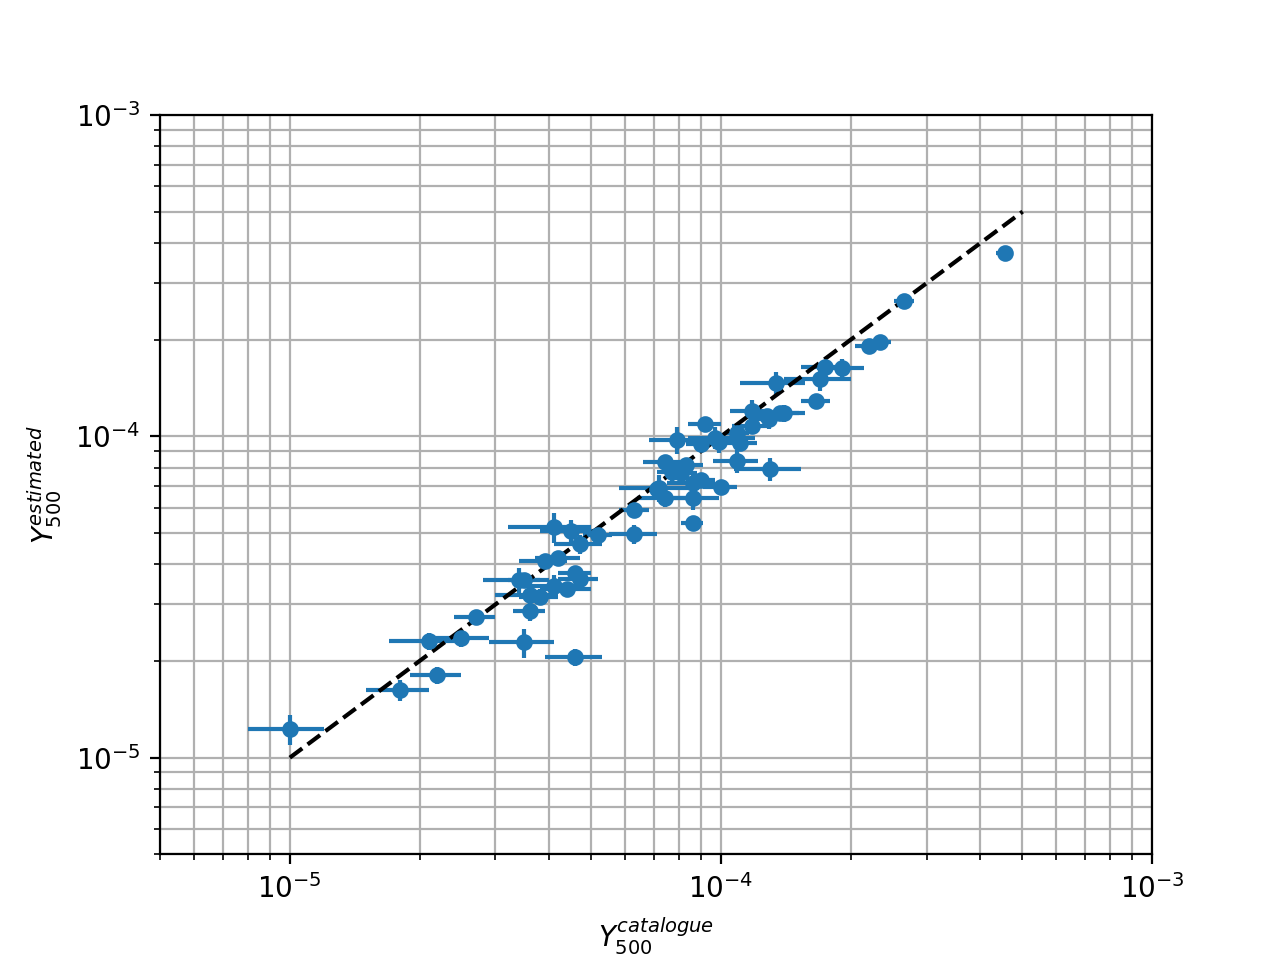

In [113]:
x=logspace(-5,-3.3,100)
figure()
errorbar(xsz_cat["YSZ_500"],xsz_cat["est_Y500_T0"],xerr=xsz_cat["YSZ_500_err"],yerr=xsz_cat["est_Y500_err_T0"],fmt='o',ms=5,label="Catalogue")
plot(x,x,"k--")
grid(which="both")
xlabel("$Y^{catalogue}_{500}$",fontsize=10)
ylabel("$Y^{estimated}_{500}$",fontsize=10)
loglog()
ylim(5e-6,1e-3)
xlim(5e-6,1e-3)
figname=figpath + "compare_Y500.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


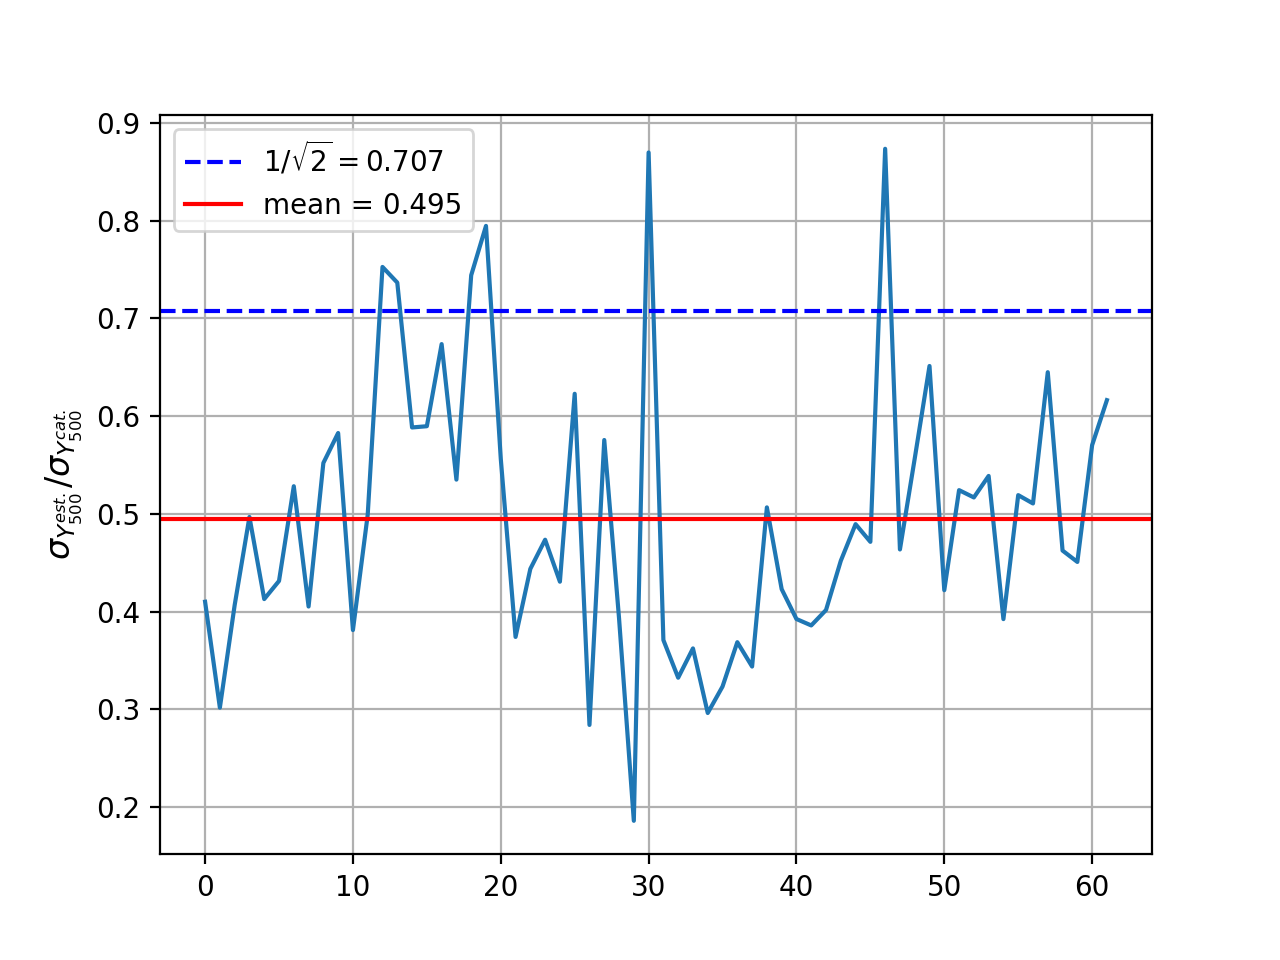

In [114]:
figure()
plot(xsz_cat["est_Y500_err_T0"]/xsz_cat["YSZ_500_err"])
#axhline(1,ls="--",c="k")
axhline(1/1.414,ls="--",c="b",label="$1/\sqrt{2}=$" + str(round(1/sqrt(2.),3)))
mu=mean(np.array(xsz_cat["est_Y500_err_T0"])/np.array(xsz_cat["YSZ_500_err"]))
axhline(mu,label="mean = "+ str(round(mu,3)),c="r")
legend(loc=0)
ylabel("$\sigma_{Y^{est.}_{500}}/\sigma_{Y^{cat.}_{500}}$",fontsize=12)
grid()
figname=figpath + "compare_Y500_err.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


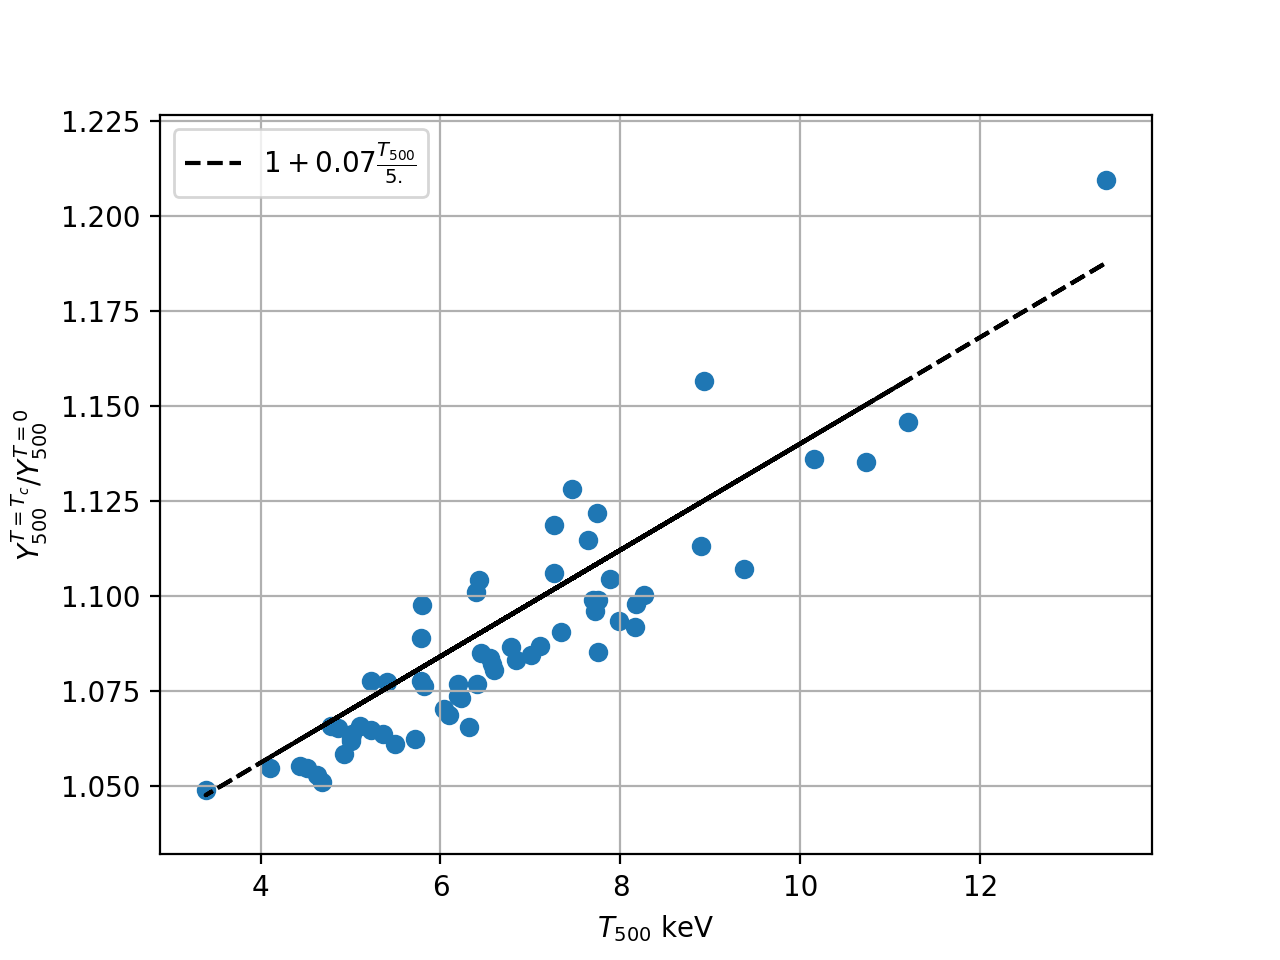

In [115]:
figure()
scatter(xsz_cat["T500"],xsz_cat["est_Y500_TT"]/xsz_cat["est_Y500_T0"])
plot(xsz_cat["T500"],1+0.07*xsz_cat["T500"]/5.,"k--",label=r"$1 + 0.07 \frac{T_{500}}{5.}$")
xlabel('$T_{500}$ keV')
ylabel('$Y^{T=T_c}_{500}/Y^{T=0}_{500}$')
grid()
legend(loc=0)
figname=figpath + "Y500_T0_vs_Y500_Tc.pdf"
savefig(figname,bbox_inches="tight")

In [116]:
# Catalogue
xdata=log10(xsz_cat["YX_500"]/1e-4)
xerr=return_log_err(xsz_cat["YX_500"]/1e-4,xsz_cat["YX_500_err"]/1e-4)
ydata=log10(xsz_cat["YSZ_500"])
yerr=return_log_err(xsz_cat["YSZ_500"],xsz_cat["YSZ_500_err"])

acat,bcat,erracat,errbcat,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
# print acat
# print erracat
# print bcat
# print errbcat


# T=0
xdata=log10(xsz_cat["YX_500"]/1e-4)
xerr=return_log_err(xsz_cat["YX_500"]/1e-4,xsz_cat["YX_500_err"]/1e-4)
ydata=log10(xsz_cat["est_Y500_T0"])
yerr=return_log_err(xsz_cat["est_Y500_T0"],xsz_cat["est_Y500_err_T0"])

aT0,bT0,erraT0,errbT0,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
# print aT0
# print erraT0
# print bT0
# print errbT0

# T=T_c
xdata=log10(xsz_cat["YX_500"]/1e-4)
xerr=return_log_err(xsz_cat["YX_500"]/1e-4,xsz_cat["YX_500_err"]/1e-4)
ydata=log10(xsz_cat["est_Y500_TT"])
yerr=return_log_err(xsz_cat["est_Y500_TT"],xsz_cat["est_Y500_err_TT"])

aTT,bTT,erraTT,errbTT,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
# print aTT
# print erraTT
# print bTT
# print errbTT

BCES, 100000 trials... 
13.841095 s
BCES, 100000 trials... 
13.198367 s
BCES, 100000 trials... 
14.682518 s


<IPython.core.display.Javascript object>


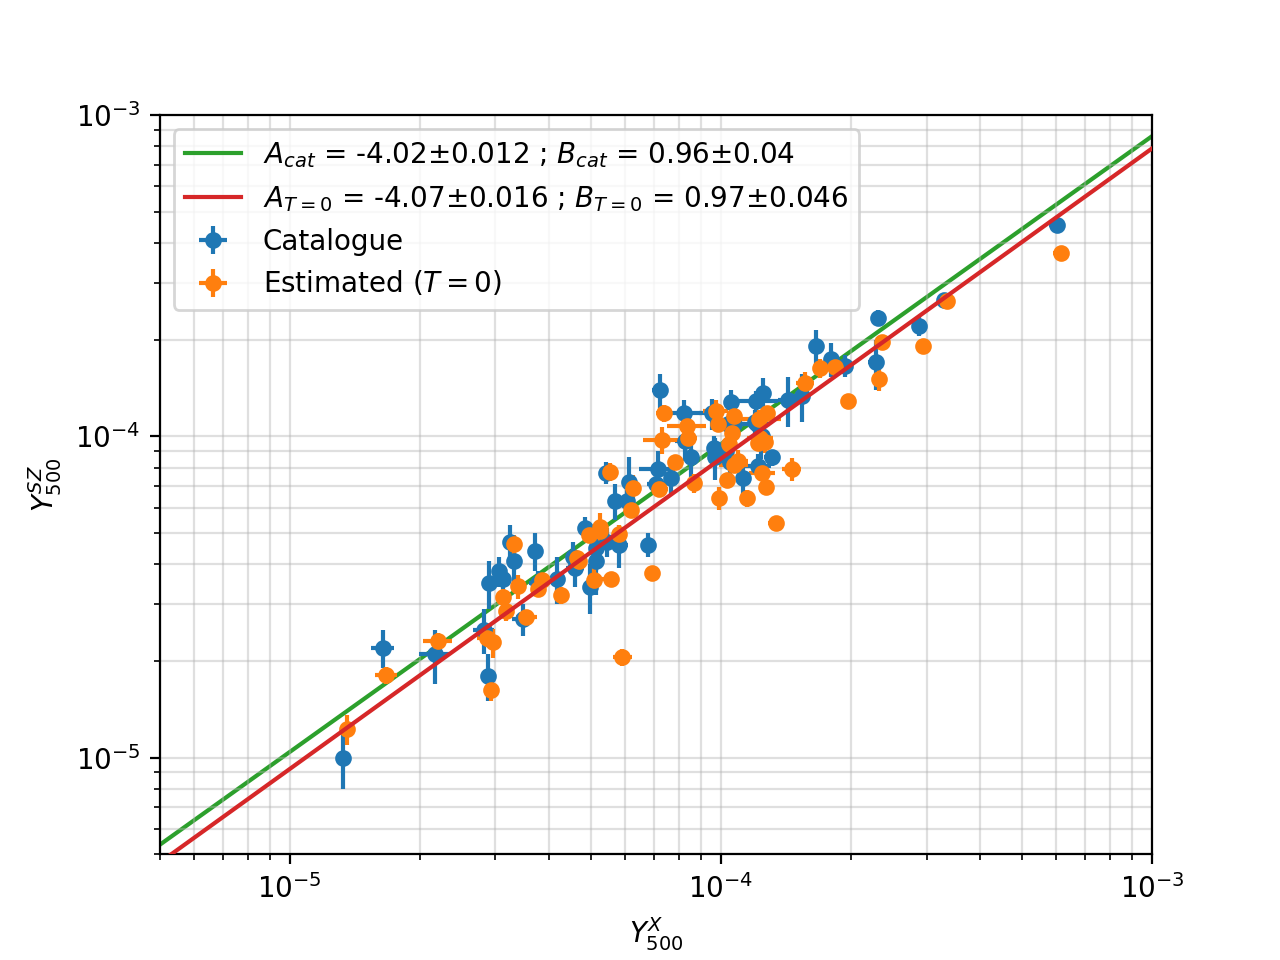

In [117]:
figure()
errorbar(xsz_cat["YX_500"],xsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=xsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Catalogue")
errorbar(xsz_cat["YX_500"]+0.02*xsz_cat["YX_500"],xsz_cat["est_Y500_T0"],xerr=xsz_cat["YX_500_err"],yerr=xsz_cat["est_Y500_err_T0"],fmt='o',ms=5,label="Estimated $(T=0)$")
tempx=linspace(5e-6,5e-3,1000)
lbl="$A_{cat}$ = " + str(round(bcat[3],2)) + "$\pm$" + str(round(errbcat[3],3)) 
lbl=lbl + " ; $B_{cat}$ = " +str(round(acat[3],2))  + "$\pm$" + str(round(erracat[3],3))
plot(tempx,(10.**bcat[3])*(tempx/1e-4)**acat[3],label=lbl,zorder=1)

lbl="$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],3)) 
lbl=lbl + " ; $B_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],3))
plot(tempx,(10.**bT0[3])*(tempx/1e-4)**aT0[3],label=lbl,zorder=3)
ylim(5e-6,1e-3)
xlim(5e-6,1e-3)
loglog()
legend(loc=0)
ylabel("$Y^{SZ}_{500}$",fontsize=10)
xlabel("$Y^X_{500}$",fontsize=10)
grid(which="both",alpha=0.4)
figname=figpath + "YSZ500_YX500_cat_vs_est.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


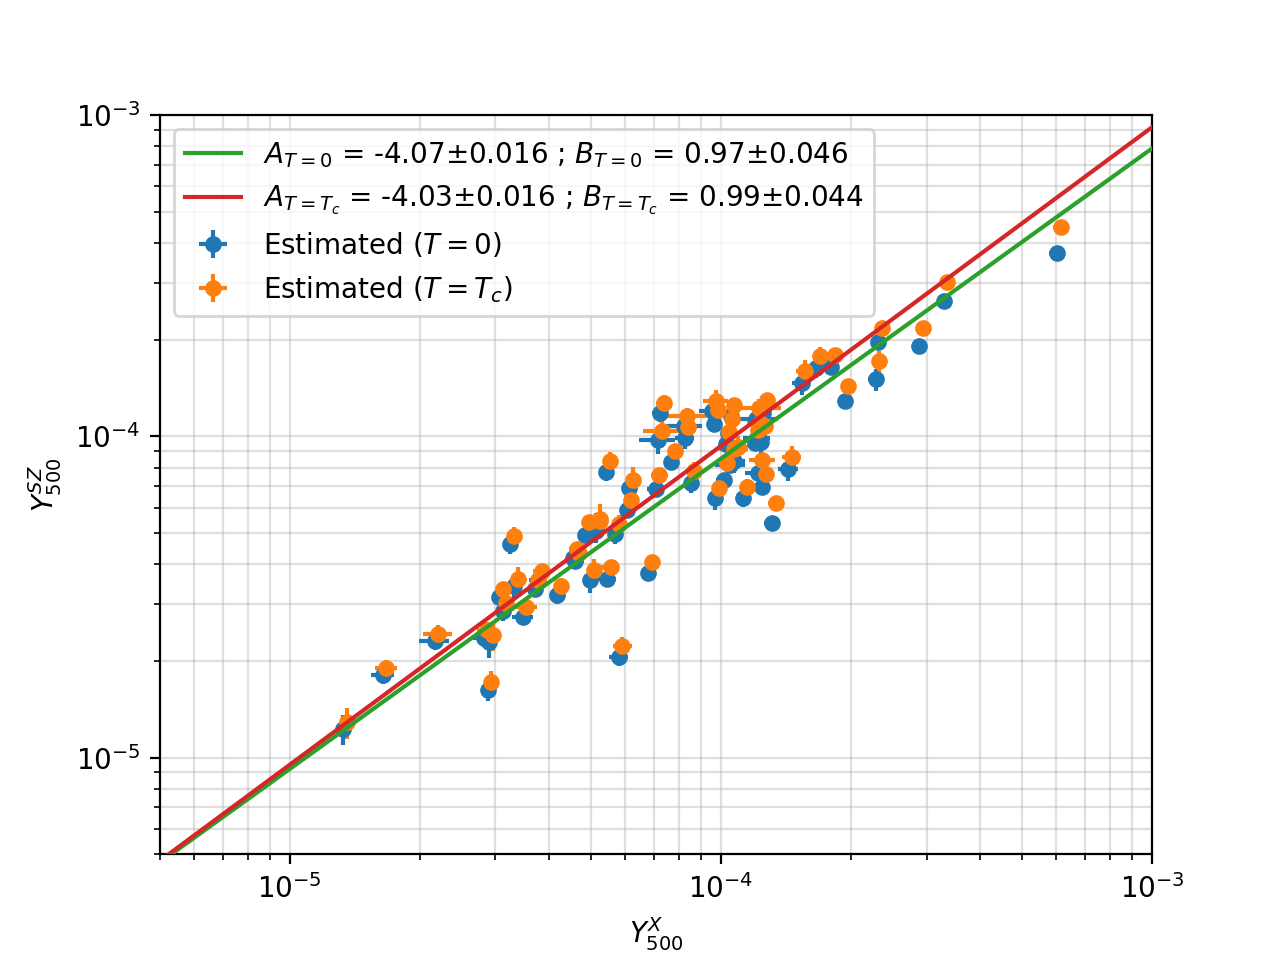

In [118]:
figure()
errorbar(xsz_cat["YX_500"],xsz_cat["est_Y500_T0"],xerr=xsz_cat["YX_500_err"],yerr=xsz_cat["est_Y500_err_T0"],fmt='o',ms=5,label="Estimated $(T=0)$")
errorbar(xsz_cat["YX_500"]+0.02*xsz_cat["YX_500"],xsz_cat["est_Y500_TT"],xerr=xsz_cat["YX_500_err"],yerr=xsz_cat["est_Y500_err_TT"],fmt='o',ms=5,label="Estimated $(T=T_c)$")
tempx=linspace(5e-6,5e-3,1000)
lbl="$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],3)) 
lbl=lbl + " ; $B_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],3))
plot(tempx,(10.**bT0[3])*(tempx/1e-4)**aT0[3],label=lbl,zorder=3)


lbl="$A_{T=T_c}$ = " + str(round(bTT[3],2)) + "$\pm$" + str(round(errbTT[3],3)) 
lbl=lbl + " ; $B_{T=T_c}$ = " +str(round(aTT[3],2))  + "$\pm$" + str(round(erraTT[3],3))
plot(tempx,(10.**bTT[3])*(tempx/1e-4)**aTT[3],label=lbl,zorder=5)

# lbl="$A_{cat}$ = " + str(round(bcat[3],2)) + "$\pm$" + str(round(errbcat[3],2)) 
# lbl=lbl + " ; $B_{cat}$ = " +str(round(acat[3],2))  + "$\pm$" + str(round(erracat[3],2))
# plot(tempx,(10.**bcat[3])*(tempx/1e-4)**acat[3],"k-",label=lbl)

ylim(5e-6,1e-3)
xlim(5e-6,1e-3)
loglog()
legend(loc=0)
ylabel("$Y^{SZ}_{500}$",fontsize=10)
xlabel("$Y^X_{500}$",fontsize=10)
grid(which="both",alpha=0.4)
figname=figpath + "YSZ500_YX500_T0_vs_TT.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


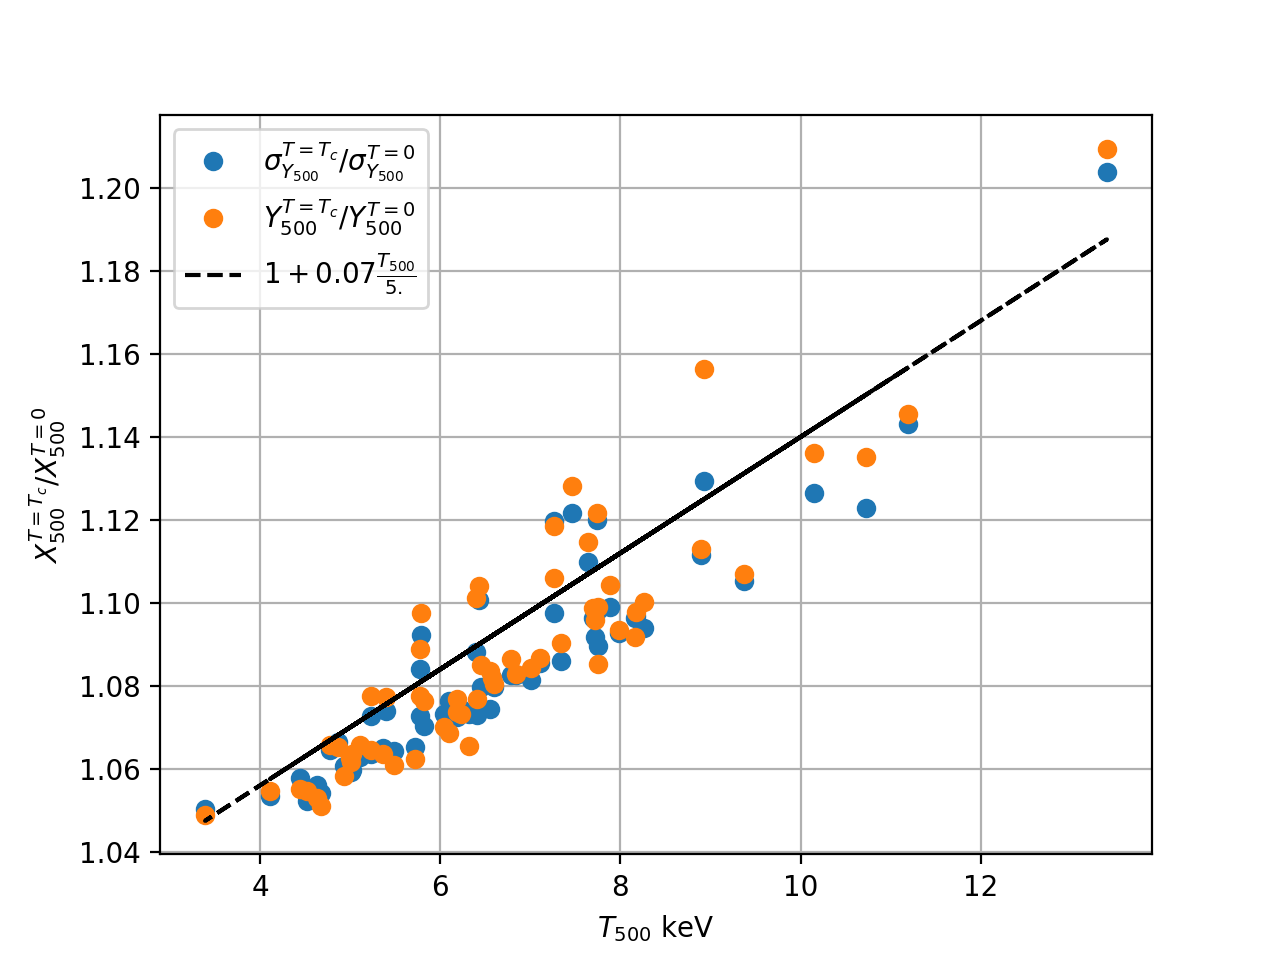

In [119]:
figure()
plot(xsz_cat["T500"],xsz_cat["est_Y500_err_TT"]/xsz_cat["est_Y500_err_T0"],"o",label="$\sigma^{T=T_c}_{Y_{500}}/\sigma^{T=0}_{Y_{500}}$")
plot(xsz_cat["T500"],xsz_cat["est_Y500_TT"]/xsz_cat["est_Y500_T0"],"o",label="$Y^{T=T_c}_{500}/Y^{T=0}_{500}$")
plot(xsz_cat["T500"],1+0.07*xsz_cat["T500"]/5.,"k--",label=r"$1 + 0.07 \frac{T_{500}}{5.}$")
xlabel('$T_{500}$ keV')
ylabel('$X^{T=T_c}_{500}/X^{T=0}_{500}$')
grid()
legend(loc=0)
figname=figpath + "Y500_vs_Y500_err.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


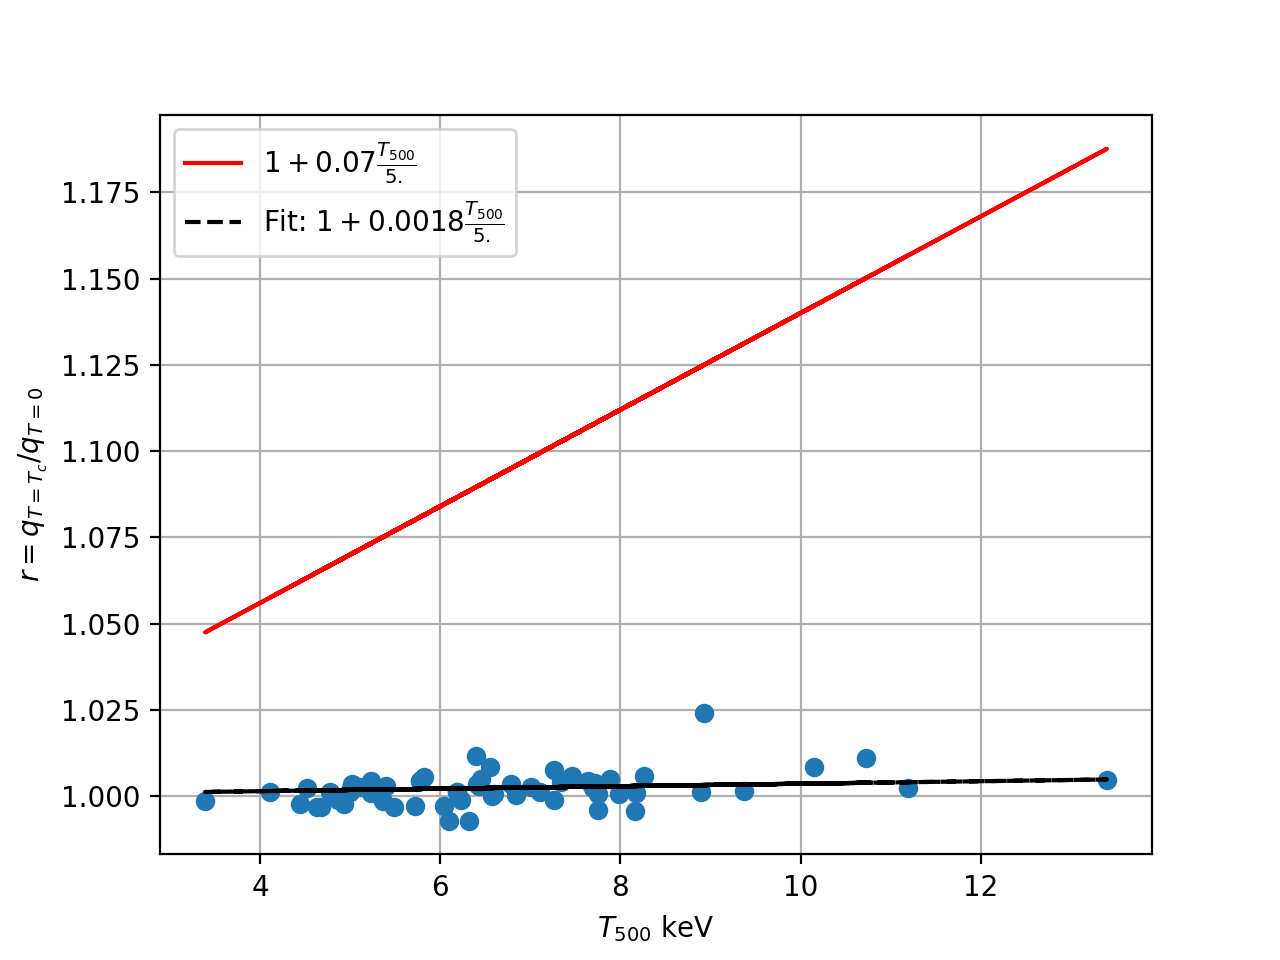

In [120]:
qT0=xsz_cat["est_Y500_T0"]/xsz_cat["est_Y500_err_T0"]
qTT=xsz_cat["est_Y500_TT"]/xsz_cat["est_Y500_err_TT"]

fn=lambda x,a: 1.+a*x/5.
slope,slope_err=curve_fit(fn,xsz_cat["T500"],qTT/qT0)

figure()
plot(xsz_cat["T500"],qTT/qT0,"o")
plot(xsz_cat["T500"],1+0.07*xsz_cat["T500"]/5.,"r-",label=r"$1 + 0.07 \frac{T_{500}}{5.}$")
plot(xsz_cat["T500"],fn(xsz_cat["T500"],slope),"k--",label="Fit: " + "$1 + $" + str(round(slope,4)) + r"$\frac{T_{500}}{5.}$")
xlabel('$T_{500}$ keV')
ylabel('$r=q_{T=T_c}/q_{T=0}$')
grid()
legend(loc=0)
figname=figpath + "SNR_qT0_qTT.pdf"
savefig(figname,bbox_inches="tight")

In [121]:
# # This produces numbers in row 2 of Table 2 from Planck early results XI (A&A 536 A11 2011)
# Ezgamma=cosmo_fn.Ez(xsz_cat["z"])**(-2./3.)
# This produces numbers in Table A.1 from Planck Collaboration: Cosmology from SZ cluster counts (2013)
Ezgamma=cosmo_fn.Ez(xsz_cat["z"])**(-2./3.)/1e-4

# Catalogue
xdata=log10(xsz_cat["M500"]/6.)
xerr=return_log_err(xsz_cat["M500"]/6.,xsz_cat["M500_err"]/6.)

ydata=log10(xsz_cat["YSZ_500"]*Ezgamma)
yerr=return_log_err(xsz_cat["YSZ_500"]*Ezgamma,xsz_cat["YSZ_500_err"]*Ezgamma)

acat,bcat,erracat,errbcat,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print acat[3],erracat[3],bcat[3],errbcat[3]


# Catalogue
xdata=log10(xsz_cat["M500"]/6.)
xerr=return_log_err(xsz_cat["M500"]/6.,xsz_cat["M500_err"]/6.)
ydata=log10(xsz_cat["est_Y500_T0"]*Ezgamma)
yerr=return_log_err(xsz_cat["est_Y500_T0"]*Ezgamma,xsz_cat["est_Y500_err_T0"]*Ezgamma)

aT0,bT0,erraT0,errbT0,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print aT0[3],erraT0[3],bT0[3],errbT0[3]

# Catalogue
xdata=log10(xsz_cat["M500"]/6.)
xerr=return_log_err(xsz_cat["M500"]/6.,xsz_cat["M500_err"]/6.)
ydata=log10(xsz_cat["est_Y500_TT"]*Ezgamma)
yerr=return_log_err(xsz_cat["est_Y500_TT"]*Ezgamma,xsz_cat["est_Y500_err_TT"]*Ezgamma)

aTT,bTT,erraTT,errbTT,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print aTT[3],erraTT[3],bTT[3],errbTT[3]

BCES, 100000 trials... 
14.196612 s
1.73579812514 0.0769922244629 -0.188263604868 0.0125912559422
BCES, 100000 trials... 
13.967032 s
1.80301165316 0.100791364158 -0.235726026385 0.0164270856116
BCES, 100000 trials... 
15.673611 s
1.8454320033 0.0970380281414 -0.200078363765 0.0164632987326


<IPython.core.display.Javascript object>


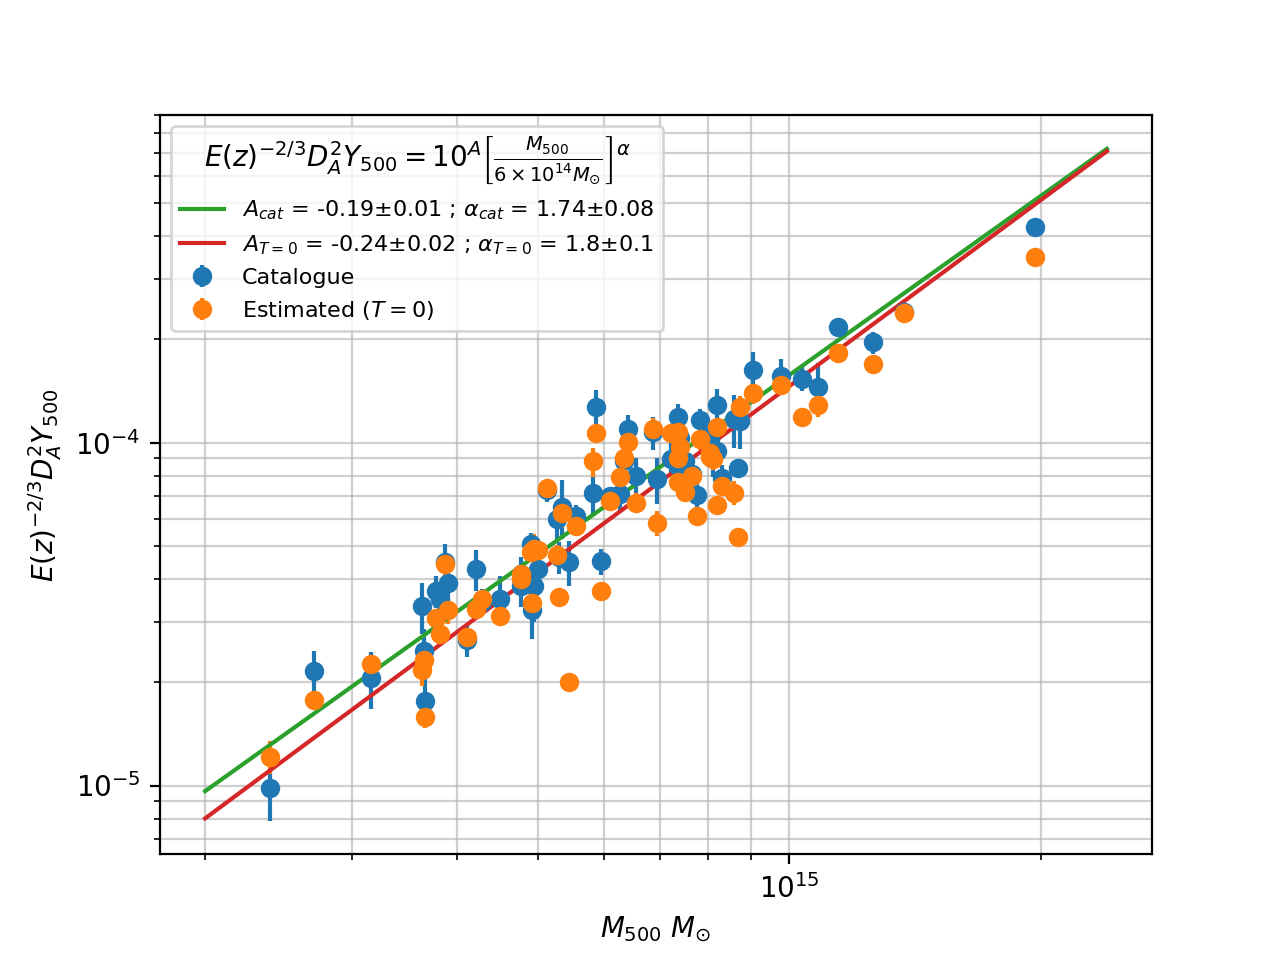

In [122]:
M500=linspace(2,24,1000)
norm=1e-4
figure()
errorbar(xsz_cat["M500"]*1e14,Ezgamma*xsz_cat["YSZ_500"]*norm,yerr=xsz_cat["YSZ_500_err"]*Ezgamma*norm,fmt="o",label="Catalogue")
errorbar(xsz_cat["M500"]*1e14,Ezgamma*xsz_cat["est_Y500_T0"]*norm,yerr=xsz_cat["est_Y500_err_T0"]*Ezgamma*norm,fmt="o",label="Estimated $(T=0)$")
#plot(M500*1e14,(10.**bcat[3])*((M500/6.)**acat[3]))

lbl=r"$A_{cat}$ = " + str(round(bcat[3],2)) + r"$\pm$" + str(round(errbcat[3],2)) 
lbl=lbl + r" ; $\alpha_{cat}$ = " +str(round(acat[3],2))  + r"$\pm$" + str(round(erracat[3],2))
plot(M500*1e14,(10.**bcat[3])*((M500/6.)**acat[3])*norm,label=lbl)

lbl=r"$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],2)) 
lbl=lbl + r" ; $\alpha_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],2))
plot(M500*1e14,(10.**bT0[3])*((M500/6.)**aT0[3])*norm,label=lbl)

ylabel(r"$E(z)^{-2/3} D^2_A Y_{500}$")
xlabel(r"$M_{500}$" + " " + "$M_{\odot}$")
lbl=r"$E(z)^{-2/3} D^2_A Y_{500} = 10^A \left[ \frac{M_{500}}{6 \times 10^{14} M_{\odot}}\right]^\alpha$"
legend(loc=0,title=lbl,fontsize=8)
loglog()
grid(which="both",alpha=0.6)
figname=figpath + "Y500_vs_M500_compare_with_cat.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


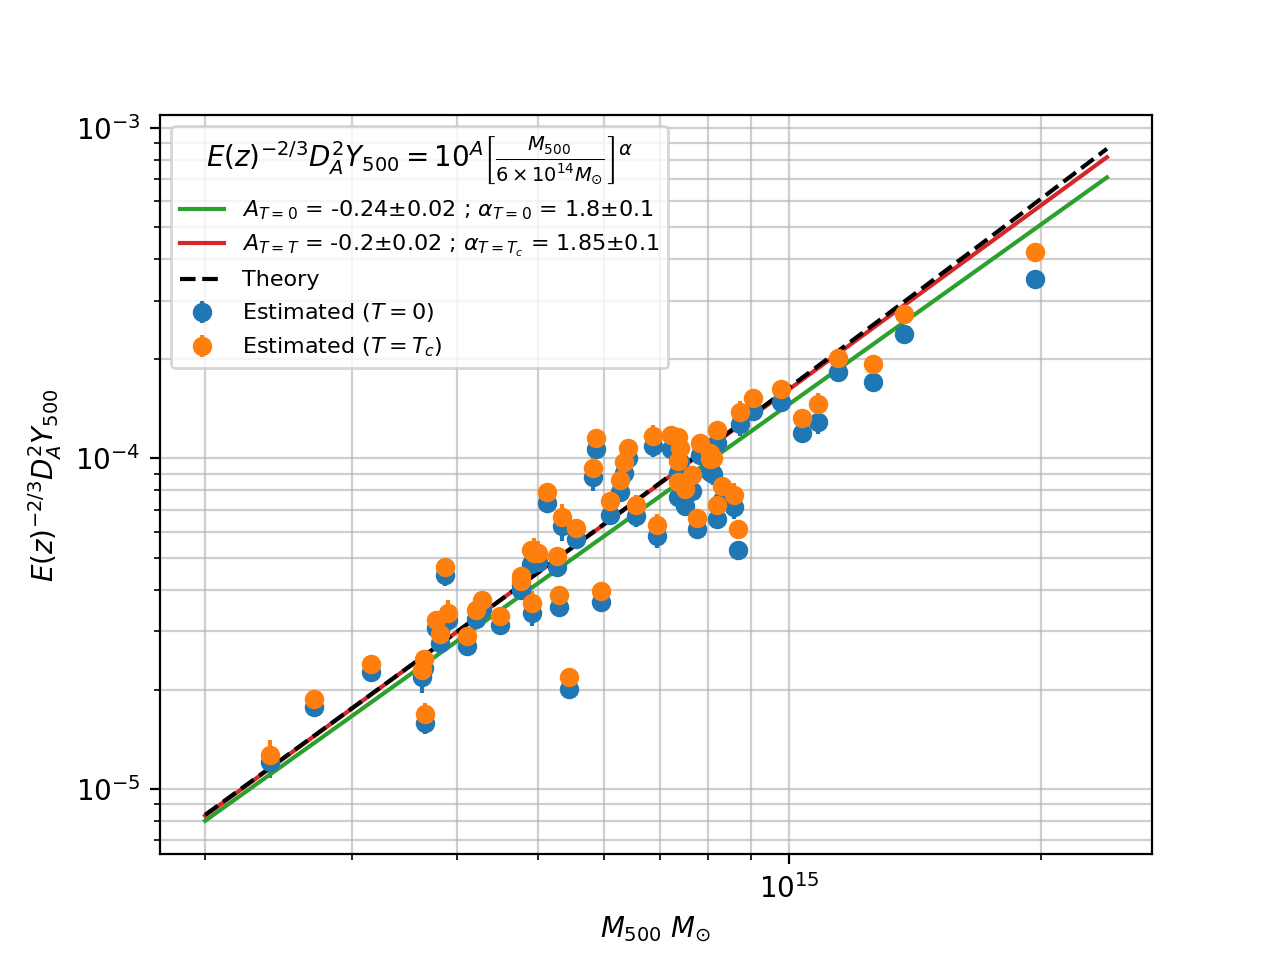

In [123]:
M500=linspace(2,24,1000)
T500=cosmo_fn.convert_M500_T500(M500,0.)
correction=1+0.07*(T500/5.)
norm=1e-4
figure()
errorbar(xsz_cat["M500"]*1e14,Ezgamma*xsz_cat["est_Y500_T0"]*norm,yerr=xsz_cat["est_Y500_err_T0"]*Ezgamma*norm,fmt="o",label="Estimated $(T=0)$")
errorbar(xsz_cat["M500"]*1e14,Ezgamma*xsz_cat["est_Y500_TT"]*norm,yerr=xsz_cat["est_Y500_err_TT"]*Ezgamma*norm,fmt="o",label="Estimated $(T=T_c)$")
#plot(M500*1e14,(10.**bcat[3])*((M500/6.)**acat[3]))

lbl=r"$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],2)) 
lbl=lbl + r" ; $\alpha_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],2))
plot(M500*1e14,(10.**bT0[3])*((M500/6.)**aT0[3])*norm,label=lbl)

lbl=r"$A_{T=T}$ = " + str(round(bTT[3],2)) + r"$\pm$" + str(round(errbTT[3],2)) 
lbl=lbl + r" ; $\alpha_{T=T_c}$ = " +str(round(aTT[3],2))  + r"$\pm$" + str(round(erraTT[3],2))
plot(M500*1e14,(10.**bTT[3])*((M500/6.)**aTT[3])*norm,label=lbl)

plot(M500*1e14,(10.**bT0[3])*((M500/6.)**aT0[3])*norm*correction,"k--",label="Theory")

ylabel(r"$E(z)^{-2/3} D^2_A Y_{500}$")
xlabel(r"$M_{500}$" + " " + "$M_{\odot}$")
lbl=r"$E(z)^{-2/3} D^2_A Y_{500} = 10^A \left[ \frac{M_{500}}{6 \times 10^{14} M_{\odot}}\right]^\alpha$"
legend(loc=0,title=lbl,fontsize=8)
loglog()
grid(which="both",alpha=0.6)
figname=figpath + "Y500_vs_M500_rSZ_correction.pdf"
savefig(figname,bbox_inches="tight")